In [1]:
from streamer import NIStreamer
from utils import iplot, RendOption
import numpy as np

### Instantiate streamer, cards, and channels

In [2]:
ni_streamer = NIStreamer()

#### Add cards

In [3]:
TRIG_LINE = 'PXI_Trig0'
REF_CLK_LINE = 'PXI_Trig7'

In [4]:
fast_ao_card = ni_streamer.add_ao_card(
    max_name='PXI1Slot3',
    nickname='fast_ao_card',
    samp_rate=1e6
)
fast_ao_card.cfg_start_trig(line=TRIG_LINE, export=True)
fast_ao_card.cfg_ref_clk(line=REF_CLK_LINE, export=True)

In [5]:
slow_ao_card = ni_streamer.add_ao_card(
    max_name='PXI1Slot4',  # 5
    samp_rate=250e3,
    nickname='slow_ao_card'
)
slow_ao_card.cfg_start_trig(line=TRIG_LINE)
# slow_ao_card.cfg_ref_clk(line=REF_CLK_LINE)

In [6]:
do_card = ni_streamer.add_do_card(
    max_name='PXI1Slot6',
    nickname='do_card',
    samp_rate=10e6
)
do_card.cfg_samp_clk_src(src=REF_CLK_LINE)
do_card.cfg_start_trig(line=TRIG_LINE)

#### Add channels

In [7]:
drive = fast_ao_card.add_chan(
    chan_idx=0, 
    nickname='drive'
)

In [8]:
src_shutter = do_card.add_chan(
    port_idx=0,
    line_idx=0,
    nickname='src_shutter'
)
src_pwr = slow_ao_card.add_chan(
    chan_idx=0,
    nickname='src_pwr'
)

In [9]:
gate = do_card.add_chan(
    port_idx=0,
    line_idx=1,
    nickname='gate'
)

### Logic script

In [10]:
ni_streamer.clear_edit_cache()

In [10]:
# Two parameters to sweep:
tau_arr = np.linspace(0.5, 10, 100) * 1e-3
pwr_arr = [0.1, 0.2, 0.5, 0.6, 1.0]

# Constant parameters
drive_amp = 0.5
drive_freq = 100e3

gate_dur = 1e-3
src_shutter_lag = 0.5e-3

safety_buf = 50e-6
inter_rep_gap = 1e-3

In [ ]:
# Convenience variable to keep track of current time:
t = 0  

for pwr in pwr_arr:
    for tau in tau_arr:
        
        # 1st gate pulse
        t += gate.high(t=t, dur=gate_dur)
        
        t += safety_buf
        
        # Sine drive pulse
        t += drive.sine(
            t=t, dur=tau,
            amp=drive_amp, freq=drive_freq
        )
        
        t += safety_buf
        
        # Simultaneous 2nd gate and source pulses
        gate.high(t=t, dur=gate_dur)
        
        src_pwr.constant(t=t, dur=gate_dur, val=pwr)
        src_shutter.high(t=t-src_shutter_lag, dur=gate_dur)
        t += gate_dur
        
        # Buffer before next repetition
        t += inter_rep_gap

In [16]:
iplot(
    chan_list=[
        gate,
        drive,
        src_pwr,
        src_shutter
    ],
#     t_start=1.60,
#     t_end=1.65,
    nsamps=int(1.2345678e5)
)

A | B | C | D
- | - | - | -
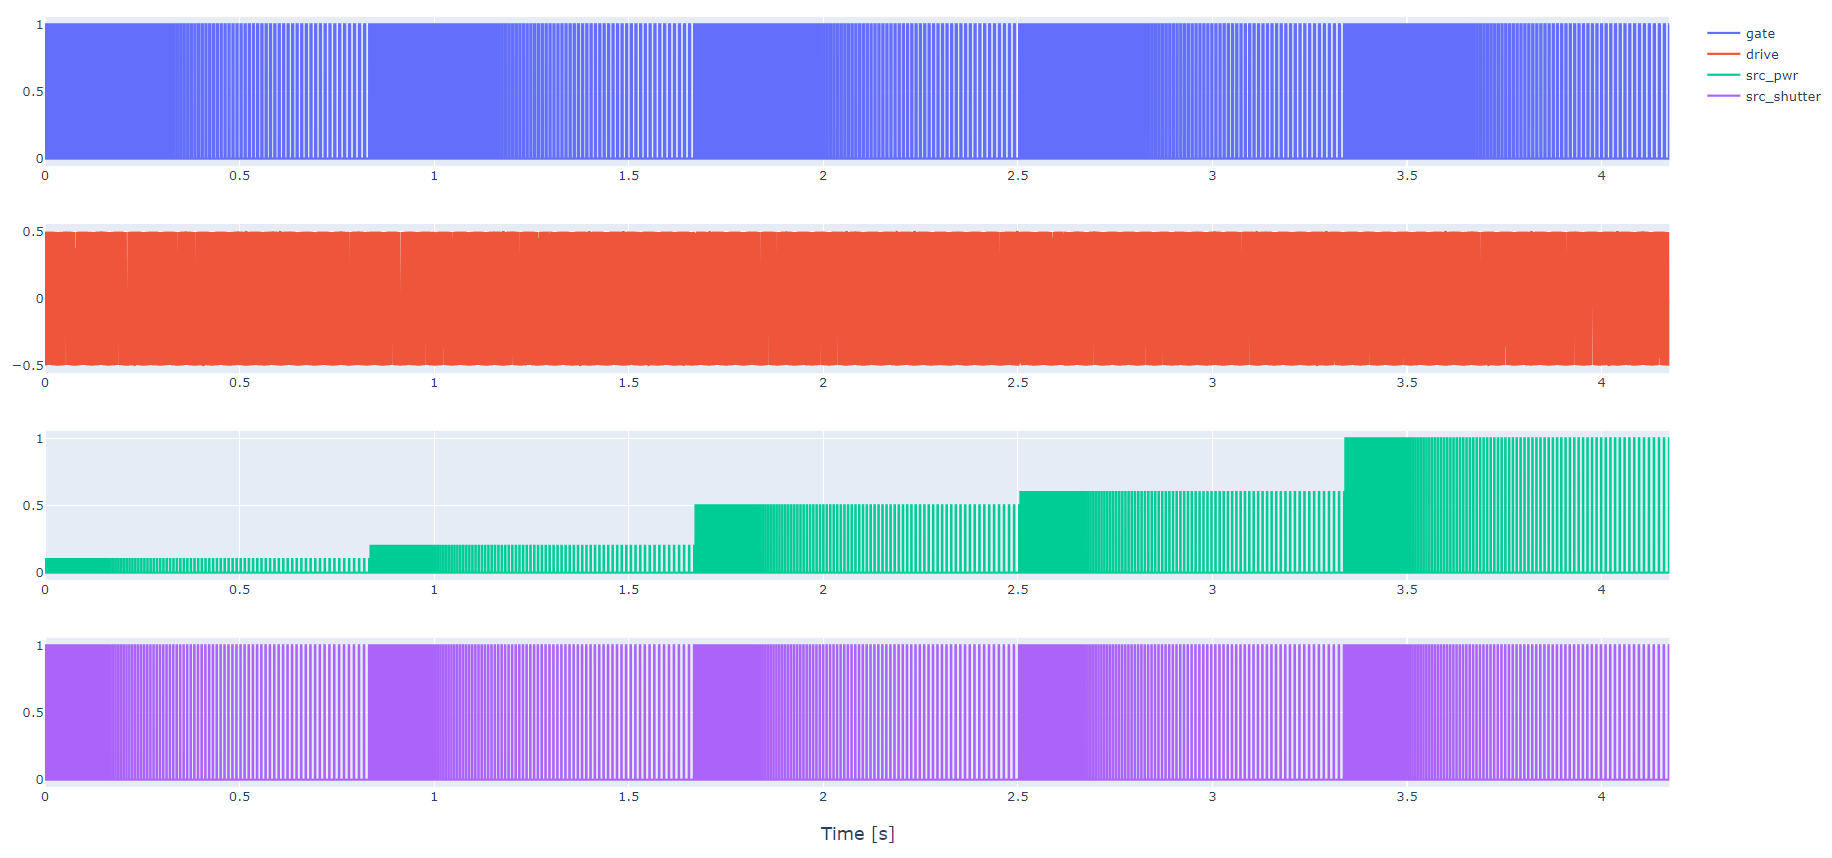 | 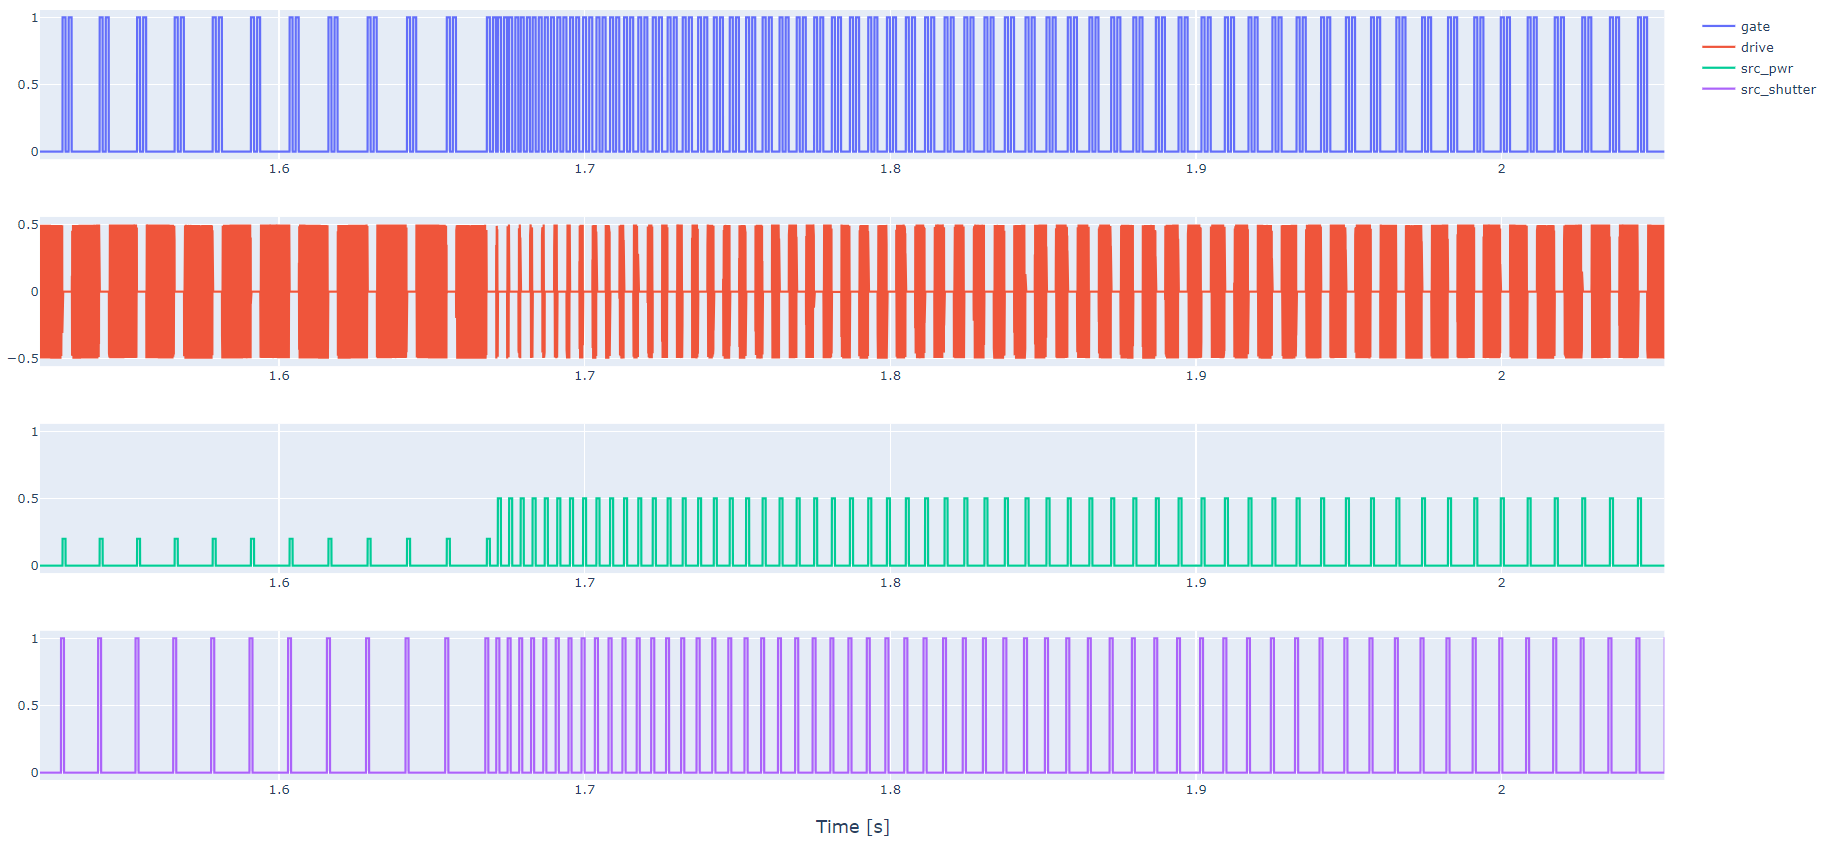 | 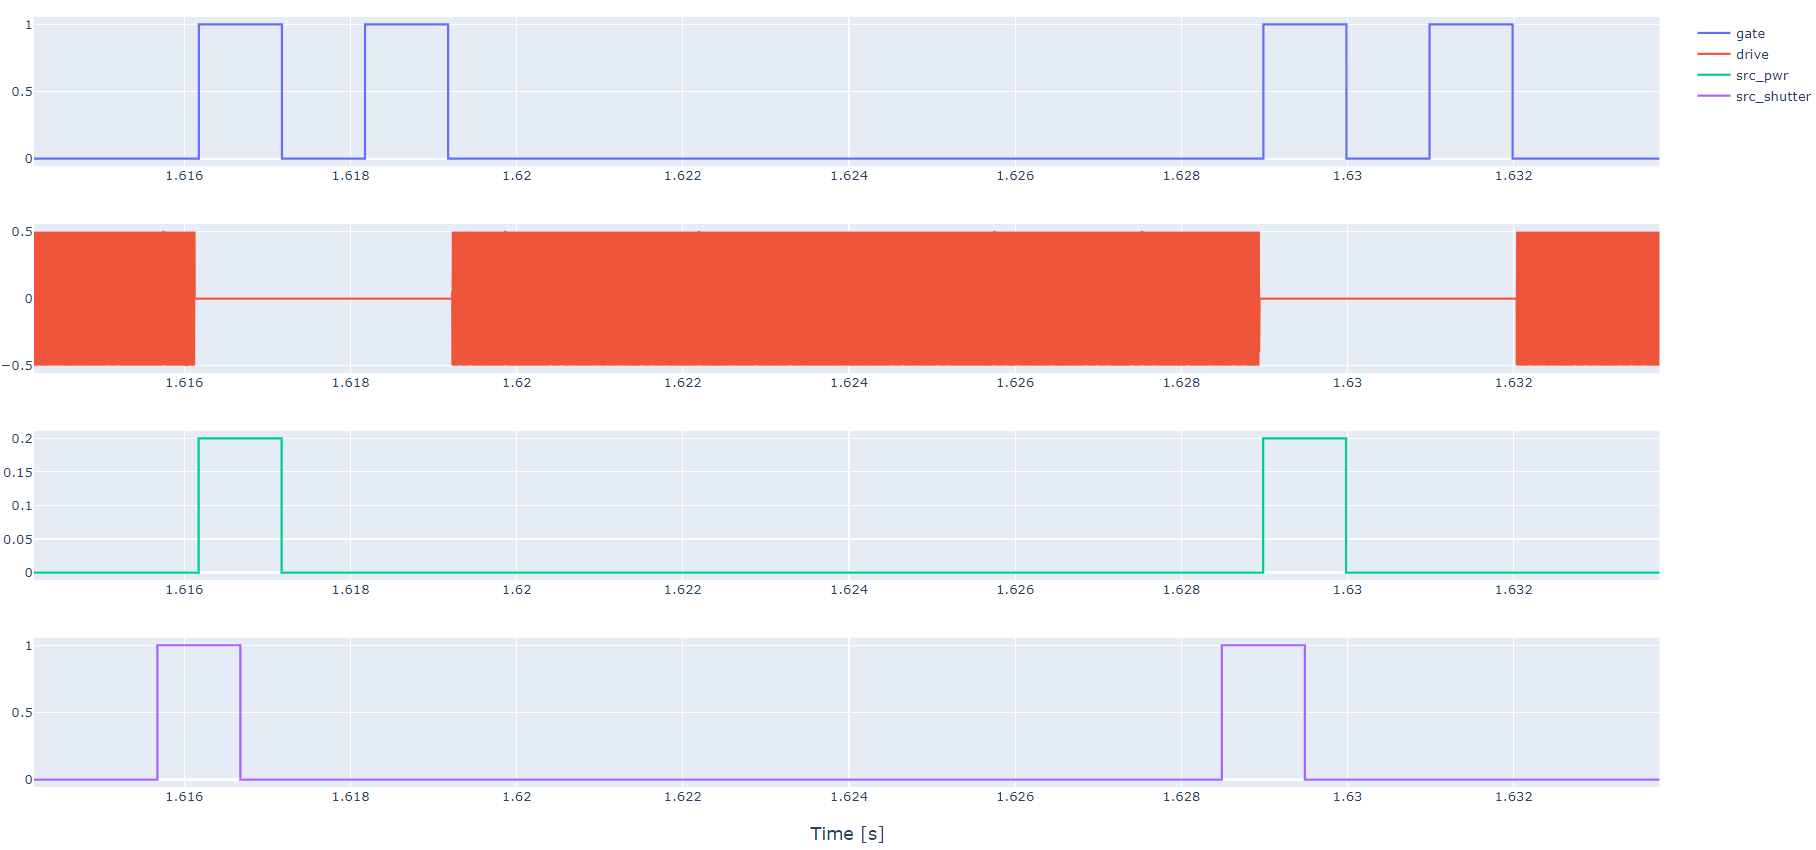 | 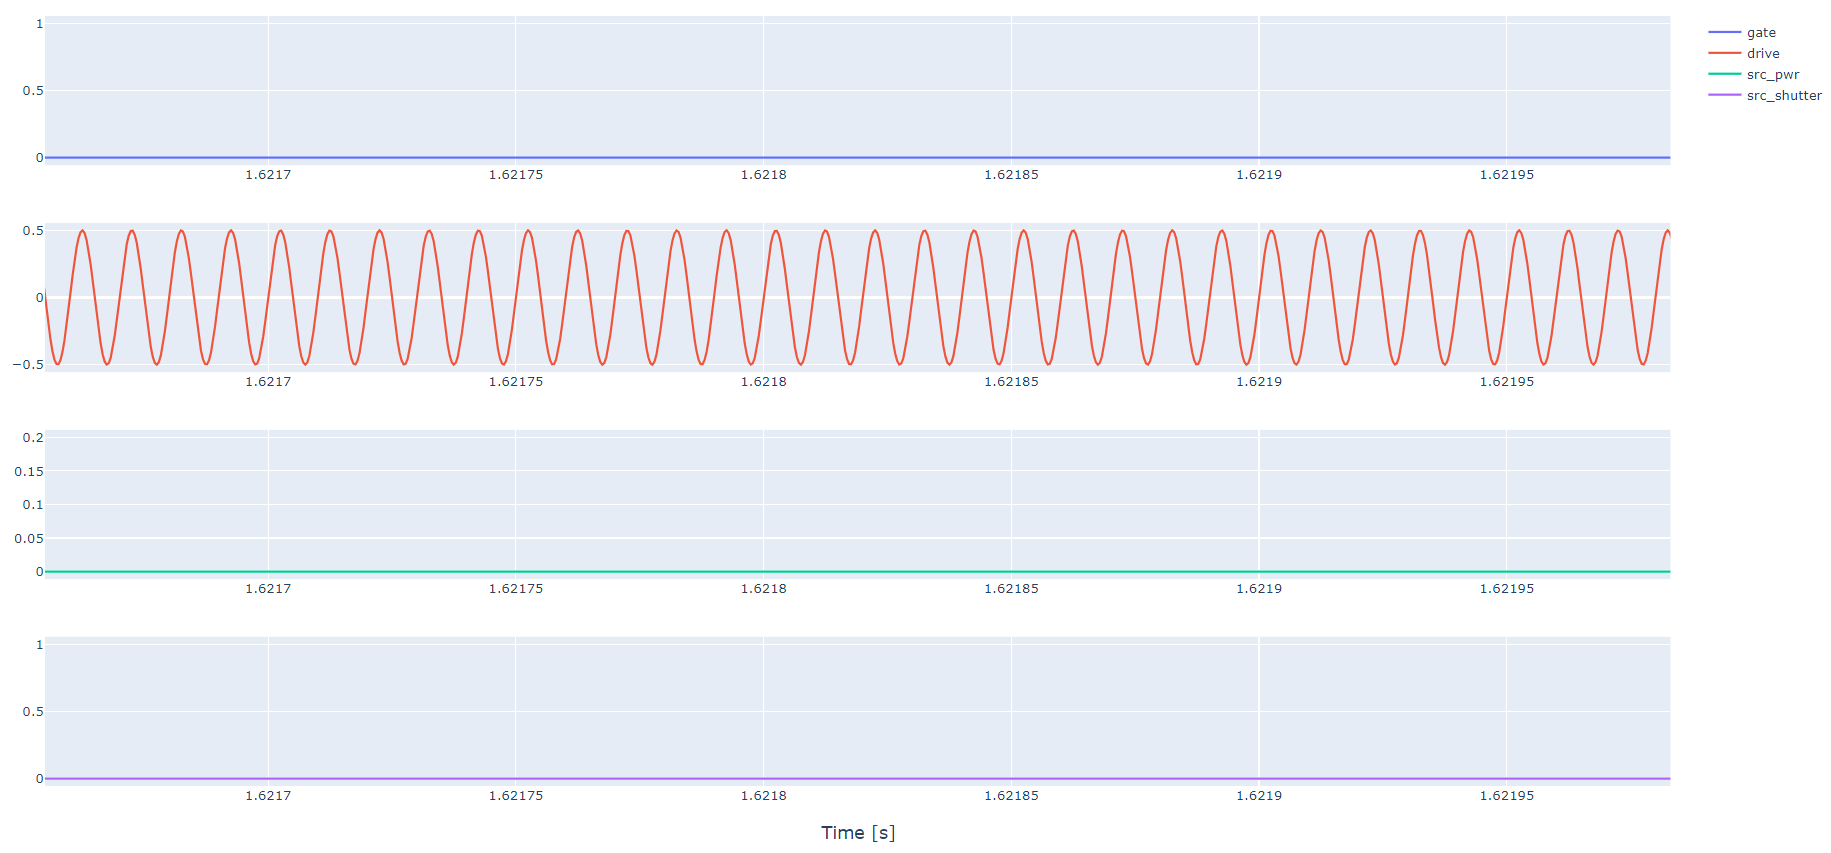

### Compile and stream

In [11]:
ni_streamer.compile()

4.1739999

In [12]:
ni_streamer.stream_exp()

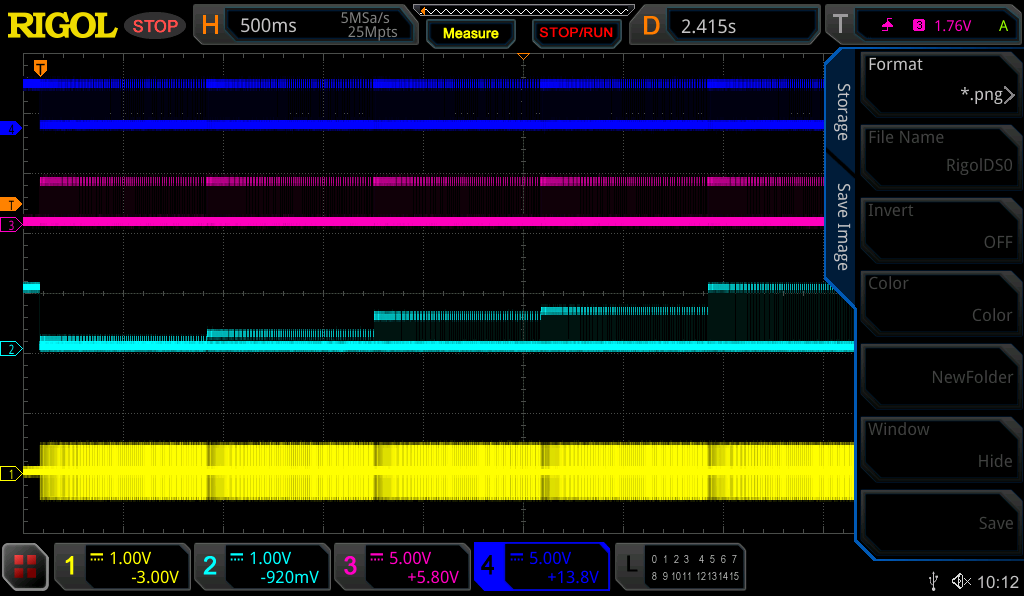

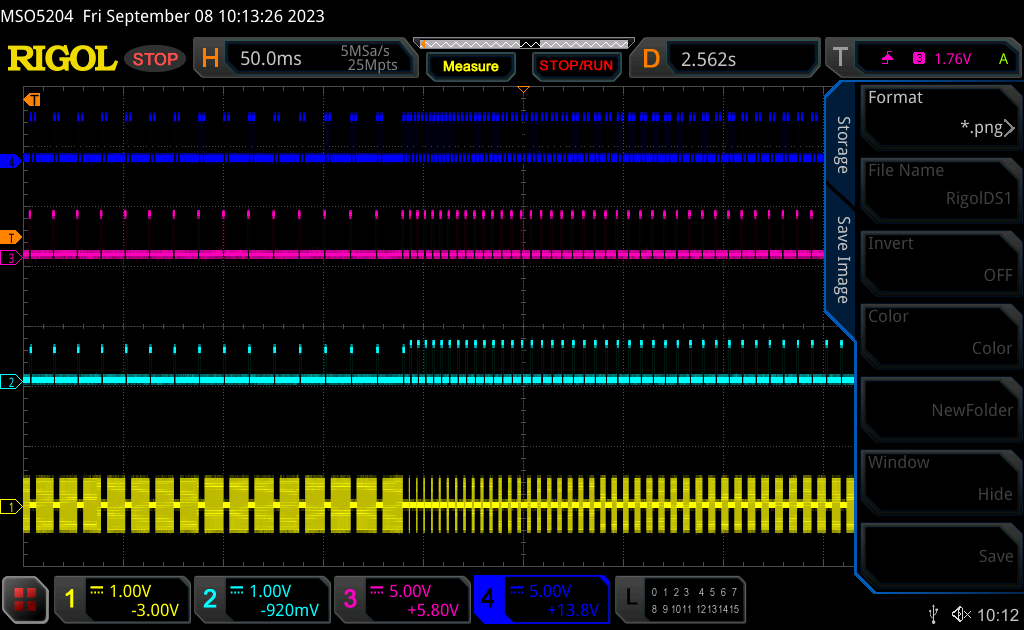

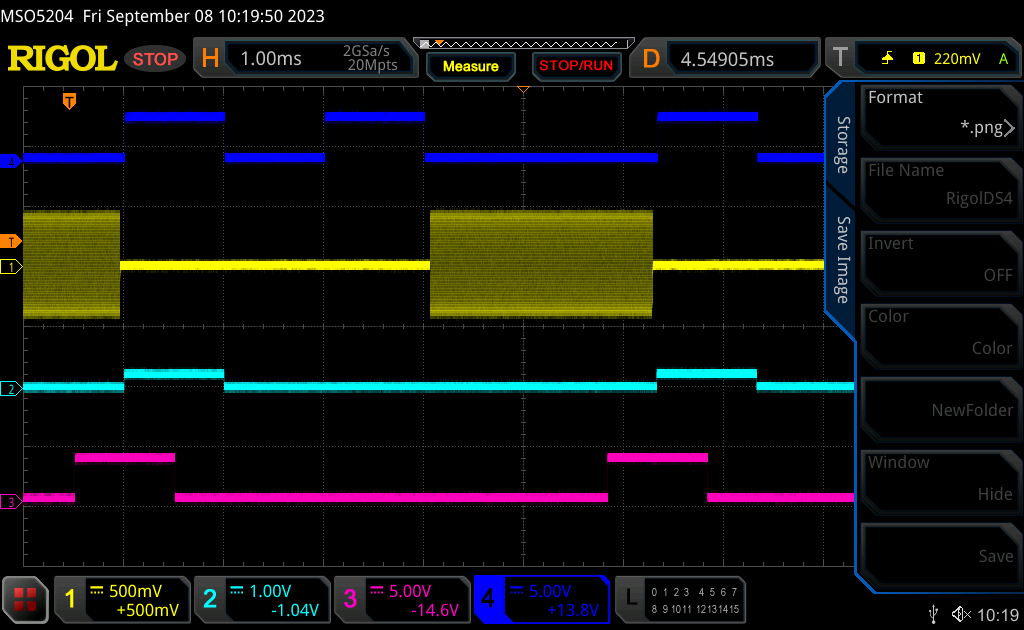

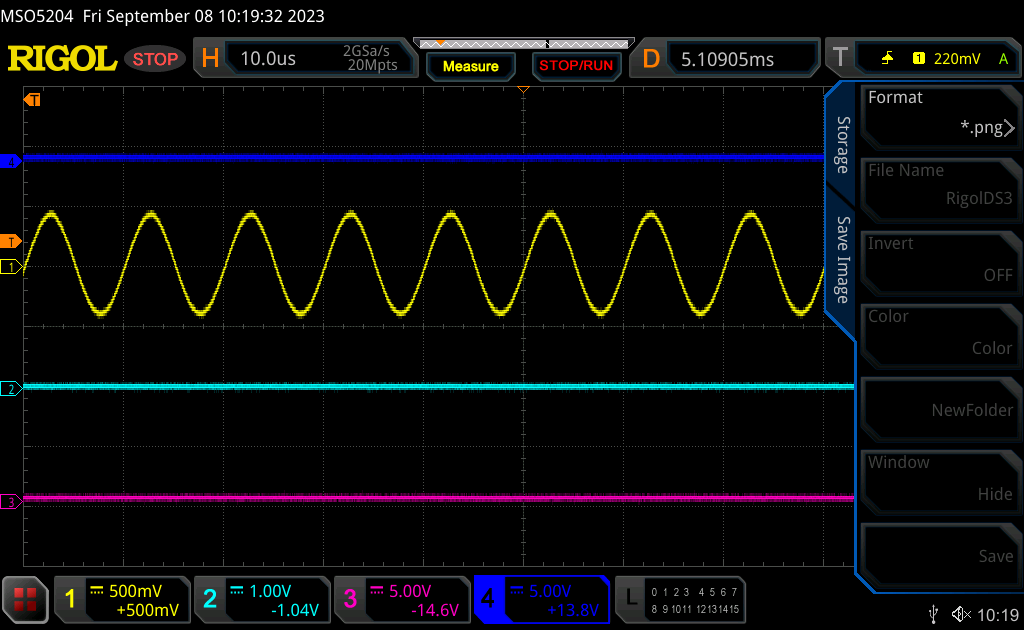

### Reset cards

In [14]:
ni_streamer.reset_all()

**ToDo** when trying to calc_signal on a channel without instructions (chech edit cache with `is_edited`):  

`src_pwr` (`slow_ao_card.ao0`) did not receive any instructions, resulting in this error

```
---------------------------------------------------------------------------
PanicException                            Traceback (most recent call last)
~\AppData\Local\Temp\ipykernel_16140\119468168.py in <module>
----> 1 iplot(
      2     chan_list=[
      3         gate,
      4         drive,
      5         src_pwr,

~\Software\NI-experiment-control\niexpctrl\utils.py in iplot(chan_list, t_start, t_end, nsamps, renderer, row_height)
     50     t_arr = None
     51     for idx, chan in enumerate(chan_list):
---> 52 
     53         t_start, t_end, signal_arr = chan.calc_signal(t_start=t_start, t_end=t_end, nsamps=nsamps)
     54 

~\Software\NI-experiment-control\niexpctrl\channel.py in calc_signal(self, t_start, t_end, nsamps)
     49         t_end = t_end if t_end is not None else self._dll.compiled_stop_time()
     50 
---> 51         signal_arr = self._dll.channel_calc_signal_nsamps(
     52             dev_name=self._card_max_name,
     53             chan_name=self.chan_name,

PanicException: Attempting to calculate signal on not-compiled channel ao0
```